In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import glob
import matplotlib.pyplot as plt

In [2]:
audio_files = glob.glob("./ravdess-emotional-speech-audio/versions/1/*/*")
print(audio_files)

['./ravdess-emotional-speech-audio/versions/1\\Actor_01\\03-01-01-01-01-01-01.wav', './ravdess-emotional-speech-audio/versions/1\\Actor_01\\03-01-01-01-01-02-01.wav', './ravdess-emotional-speech-audio/versions/1\\Actor_01\\03-01-01-01-02-01-01.wav', './ravdess-emotional-speech-audio/versions/1\\Actor_01\\03-01-01-01-02-02-01.wav', './ravdess-emotional-speech-audio/versions/1\\Actor_01\\03-01-02-01-01-01-01.wav', './ravdess-emotional-speech-audio/versions/1\\Actor_01\\03-01-02-01-01-02-01.wav', './ravdess-emotional-speech-audio/versions/1\\Actor_01\\03-01-02-01-02-01-01.wav', './ravdess-emotional-speech-audio/versions/1\\Actor_01\\03-01-02-01-02-02-01.wav', './ravdess-emotional-speech-audio/versions/1\\Actor_01\\03-01-02-02-01-01-01.wav', './ravdess-emotional-speech-audio/versions/1\\Actor_01\\03-01-02-02-01-02-01.wav', './ravdess-emotional-speech-audio/versions/1\\Actor_01\\03-01-02-02-02-01-01.wav', './ravdess-emotional-speech-audio/versions/1\\Actor_01\\03-01-02-02-02-02-01.wav', './

In [3]:
file_4, m = librosa.load(audio_files[4])

In [4]:
print(file_4, m)

[ 1.2775290e-05  5.2579480e-07 -5.9776858e-07 ...  6.3326383e-10
 -5.2984428e-10  4.3437093e-10] 22050


<Axes: >

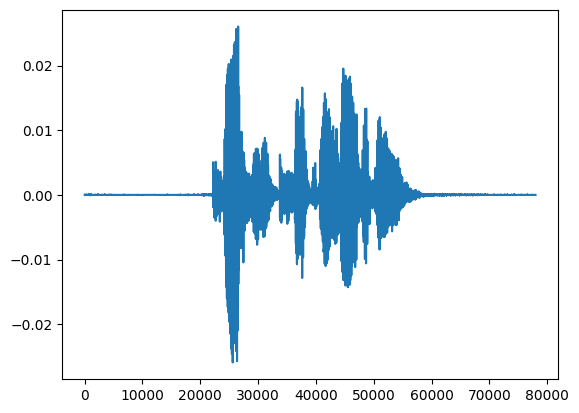

In [5]:
# Plot the audio
pd.Series(file_4).plot()

In [6]:
file_4 , _ = librosa.effects.trim(file_4, top_db=10)

<Axes: >

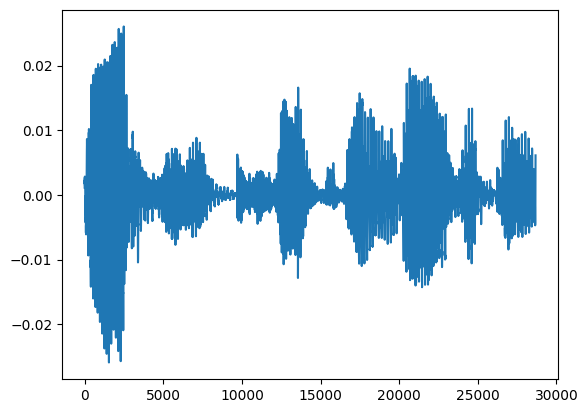

In [7]:
# Plot again the new version of the audio
pd.Series(file_4).plot()

<Axes: >

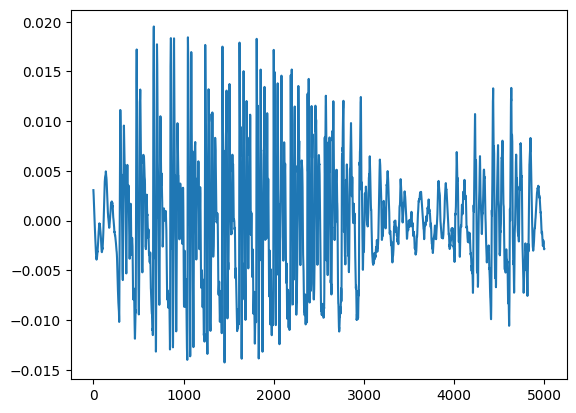

In [8]:
# Doing a zoom in our wave
pd.Series(file_4[20000:25000]).plot()

<Axes: >

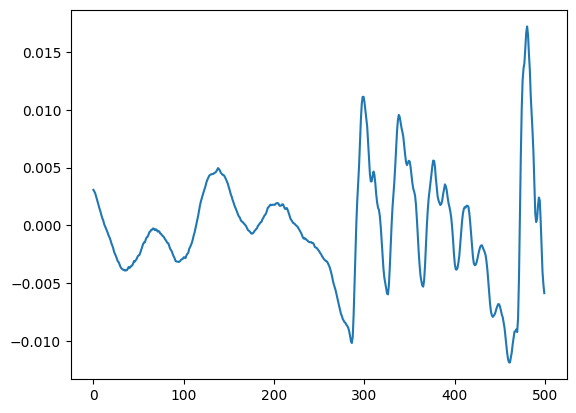

In [9]:
# Zooming more
pd.Series(file_4[20000:20500]).plot()

In [10]:
# We apply short time fourier transform
file_4_transformed = librosa.stft(file_4)


In [11]:
# We make the spectogram
spectogram = np.abs(file_4_transformed)
spectogram_db = librosa.amplitude_to_db(spectogram)

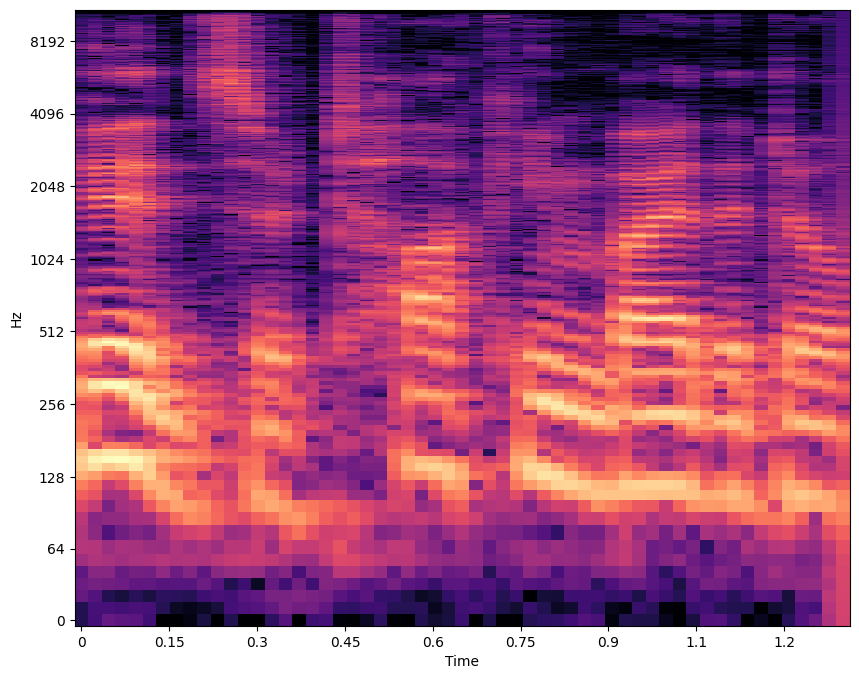

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
spec_image = librosa.display.specshow(spectogram_db, x_axis="time", y_axis="log", ax=ax)